<a href="https://colab.research.google.com/github/EstebanCabreraArbizu/Trabajo_academico-Machine_Learning/blob/main/TF_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TP-Trabajo Parcial / Final
## Objetivo
* Redactar la descripción y fundamentación de la situación real,
utilizando como fuentes los informes correspondientes a las Tareas Académicas 1 y 2 (TA1/TA2).
* Cada grupo obtendrá los datos según requerimiento del Científico de Datos, a partir de
distintas fuentes/origen propuestas (ver detalle en Anexo 1)
## Integrantes:
* Esteban Fabricio Cabrera Arbizu
* Marcelo Guerrero

## Adquisición y Preprocesamientos de los Datos

In [ ]:
import requests

def get_all_categories():
    url = "https://pro-api.coinmarketcap.com/v1/cryptocurrency/categories"
    headers = {
        'Accepts': 'application/json',
        'X-CMC_PRO_API_KEY': 'd7467015-2757-4138-8cea-04372117e884',
    }

    response = requests.get(url, headers=headers)
    data = response.json()

    return data

def get_related_categories(category):
    all_categories = get_all_categories()
    related_categories = []
    if all_categories and 'data' in all_categories:
      related_categories = [cat['name'] for cat in all_categories['data'] if category in cat['name']]

    return related_categories

category = 'Gaming'  # Reemplaza esto con la categoría que deseas consultar
data = get_related_categories(category)
print(data)


['Gaming Guild', 'Gaming']


In [ ]:
import asyncio
import nest_asyncio
from aiohttp import ClientSession, ClientResponseError
from tqdm.asyncio import tqdm

# Apply nest_asyncio for compatibility with environments that have a running loop
nest_asyncio.apply()
global_cryptos_info = None
# API details
BASE_URL = "https://pro-api.coinmarketcap.com/"
API_KEY = "d7467015-2757-4138-8cea-04372117e884"
HEADERS = {
    "X-CMC_PRO_API_KEY": API_KEY,
    "Accept": "application/json",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
}

async def fetch_crypto_data(session, endpoint):
    """ Fetches data from the given API endpoint with specified parameters. """
    url = f"{BASE_URL}{endpoint}"
    try:
        async with session.get(url, headers=HEADERS) as response:
            response.raise_for_status()  # This will raise an exception for HTTP error responses
            data = await response.json()
            print("API Response:", data)  # Debugging output to inspect the raw API response
            return data
    except ClientResponseError as e:
        print(f"Failed to fetch data: {e}")
        return None

async def get_related_categories(session, categories):
    endpoint = "v1/cryptocurrency/categories"
    all_categories = await fetch_crypto_data(session, endpoint)
    related_categories = []
    if all_categories and "data" in all_categories:
      for category in categories:
        related_categories.extend([cat['name'] for cat in all_categories["data"] if category in cat['name']])

    return related_categories

async def filter_cryptos_by_category(session, categories):
    """ Filters cryptocurrencies by specified categories after fetching them. """
    endpoint = "v1/cryptocurrency/categories"
    data = await fetch_crypto_data(session, endpoint)
    filtered_ids = set()

    if data and "data" in data:
        for category in data['data']:
            if category["name"] in categories:
                filtered_ids.add(category["id"])

    return filtered_ids

async def obtain_crypto_ids(session, id_c):
    endpoint = "v1/cryptocurrency/category"
    params = {"id": str(id_c)}
    url = f"{BASE_URL}{endpoint}"
    yield_ids = set()
    try:
        async with session.get(url, headers = HEADERS, params = params) as response:
            response.raise_for_status()
            data = await response.json()
            name = data["data"]["name"]
            for i in data["data"]["coins"]:
                id = i["id"]
                if id not in yield_ids:
                    yield_ids.add(id)
            return yield_ids, name
    except ClientResponseError as e:
        print(f"Failed to fetch data: {e}")
        return None

async def get_crypto_data(crypto_id, category):
    url = f"{BASE_URL}v1/cryptocurrency/quotes/latest"
    async with ClientSession() as session:
        try:
            async with session.get(url, params={"id": str(crypto_id)}, headers=HEADERS) as response:
                response.raise_for_status()
                await asyncio.sleep(5)  # Espera 5 segundos entre las solicitudes
                data_quotes = await response.json()  # Esperar la respuesta JSON
                if "data" in data_quotes and str(crypto_id) in data_quotes["data"]:
                    quote_data = data_quotes["data"][str(crypto_id)]["quote"]["USD"]
                    valor_activo_usd = quote_data["price"]
                    capitalizacion_total_mercado = quote_data["market_cap"]
                    posicion_en_ranking = data_quotes["data"][str(crypto_id)]["cmc_rank"]
                    volumen_24h = quote_data["volume_24h"]
                    porcentaje_volumen_diario = quote_data["percent_change_24h"]
                    suministro_circulante = data_quotes["data"][str(crypto_id)]["circulating_supply"]
                    suministro_total = data_quotes["data"][str(crypto_id)]["total_supply"]
                    suministro_maximo = data_quotes["data"][str(crypto_id)]["max_supply"]

                    required_data = {
                        'Coin ID': crypto_id,
                        'Valor del activo (en US$)': valor_activo_usd,
                        'Capitalización total de mercado (market cap)': capitalizacion_total_mercado,
                        'Volumen (volumen 24h)': volumen_24h,
                        'Porcentaje del volumen diario (volumen 24h / market cap)': porcentaje_volumen_diario,
                        'Suministro circulante (circulating supply)': suministro_circulante,
                        'Suministro total (total supply)': suministro_total,
                        'Suministro máximo (max supply)': suministro_maximo,
                        'Posición en ranking': posicion_en_ranking,
                        'Categoría': category
                    }
                    return required_data
                else:
                    print(f"No se encontraron datos para el crypto ID {crypto_id}")
                    return None
        except ClientResponseError as cre:
            print(f"Error en la respuesta del cliente: {cre}")
            return None


async def filter_quotes_by_category_async(crypto_ids, categories):
    async with ClientSession() as session:
        try:
            information = []
            for label, i in zip(categories, crypto_ids):
                for enum in i:
                    quotes_data = await get_crypto_data(enum, label)
                    if quotes_data != None:
                        information.append(quotes_data)
            return information
        except ClientResponseError as cre:
            print(f"Client response error occurred: {cre}")
            return None, None


async def main():
    global global_cryptos_info
    categories = ['Memes', 'Gaming', 'AI']  # Desired categories
    async with ClientSession() as session:
        related_categories = await get_related_categories(session, categories)
        category_ids = await filter_cryptos_by_category(session, related_categories)
        category_ids = list(category_ids)
        print("Filtered Category IDs:", category_ids, "type: ", type(category_ids))
        ids = []
        names = []
        for id in category_ids:
            crypto_id, name = await obtain_crypto_ids(session, id)
            crypto_id = list(crypto_id)
            ids.append(crypto_id)
            names.append(name)
        print(f"Filtered IDs: {ids}")
        print(f"Names of category: {names}")

        # Filtrar y guardar la información importante
        cryptos_info = await filter_quotes_by_category_async(ids, related_categories)
        print("Filtered Cryptos Information:", cryptos_info)
        global_cryptos_info = cryptos_info
    info = cryptos_info
if __name__ == "__main__":
    asyncio.run(main())
print(global_cryptos_info)

API Response: {'status': {'timestamp': '2024-06-28T06:33:15.231Z', 'error_code': 0, 'error_message': None, 'elapsed': 303, 'credit_count': 1, 'notice': None}, 'data': [{'id': '664716e98c23b0279034a5ed', 'name': 'Political Memes', 'title': 'Political Memes', 'description': 'Political Memes', 'num_tokens': 54, 'avg_price_change': -4.860092112500001, 'market_cap': 507619897.71, 'market_cap_change': -0.8792062500000001, 'volume': 245250621.82615697, 'volume_change': 271.1102104166667, 'last_updated': '2024-05-22T02:12:33.978Z'}, {'id': '663dd07040575e0870396c23', 'name': 'Rehypothecated Crypto', 'title': 'Rehypothecated Crypto', 'description': 'Rehypothecated Crypto', 'num_tokens': 148, 'avg_price_change': 2.5252541086131397, 'market_cap': 116587312522.76994, 'market_cap_change': 2.3256664233576645, 'volume': 4563732240.708557, 'volume_change': 194193.0425635037, 'last_updated': '2024-05-10T07:47:43.754Z'}, {'id': '6634dccba7b6f0637eec196a', 'name': 'Fiat Stablecoin', 'title': 'Fiat Stable

In [ ]:
import pandas as pd
df = pd.DataFrame(global_cryptos_info)
df

,Coin ID,Valor del activo (en US$),Capitalización total de mercado (market cap),Volumen (volumen 24h),Porcentaje del volumen diario (volumen 24h / market cap),Suministro circulante (circulating supply),Suministro total (total supply),Suministro máximo (max supply),Posición en ranking,Categoría
0,25093,NaN,NaN,0.000000e+00,0.000000,0.000000e+00,7.640000e+07,7.640000e+07,NaN,Political Memes
1,14345,0.752685,3.543165e+07,7.569134e+05,2.690078,4.707368e+07,1.000000e+08,1.000000e+08,640.0,Political Memes
2,8230,0.014743,0.000000e+00,7.086302e+04,-3.597359,0.000000e+00,7.000000e+08,7.000000e+08,3905.0,Political Memes
3,27178,0.278434,2.279060e+08,3.609437e+06,2.314431,8.185281e+08,1.000000e+09,1.000000e+09,228.0,Political Memes
4,29750,0.110345,0.000000e+00,2.584294e+03,5.031140,0.000000e+00,1.000000e+08,1.000000e+08,5743.0,Political Memes
...,...,...,...,...,...,...,...,...,...,...
450,13133,0.000035,8.013068e+03,5.803508e+04,1.260110,2.266625e+08,3.133843e+08,NaN,2483.0,AI & Big Data
451,13523,1.642686,0.000000e+00,5.511797e+03,-1.956369,0.000000e+00,6.698112e+08,NaN,5392.0,AI & Big Data
452,15585,0.235662,5.943470e+07,4.549342e+02,5.558502,2.522029e+08,1.000000e+09,1.000000e+09,505.0,AI & Big Data
453,15588,NaN,NaN,0.000000e+00,0.000000,0.000000e+00,1.000000e+09,1.000000e+09,NaN,AI & Big Data


In [ ]:
df.to_csv('cryptos_info.csv', index=False)

## Exploración de los datos

In [ ]:
import numpy as np                # linear algebra
import pandas as pd               # data frames
import seaborn as sns             # visualizations
import matplotlib.pyplot as plt   # visualizations
import scipy.stats                # statistics
from scipy import stats

df = pd.read_csv('cryptos_info.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 10 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Coin ID                                                   455 non-null    int64  
 1   Valor del activo (en US$)                                 439 non-null    float64
 2   Capitalización total de mercado (market cap)              439 non-null    float64
 3   Volumen (volumen 24h)                                     455 non-null    float64
 4   Porcentaje del volumen diario (volumen 24h / market cap)  455 non-null    float64
 5   Suministro circulante (circulating supply)                455 non-null    float64
 6   Suministro total (total supply)                           455 non-null    float64
 7   Suministro máximo (max supply)                            287 non-null    float64
 8   Posición en ranking 

In [ ]:
df.shape

(455, 10)

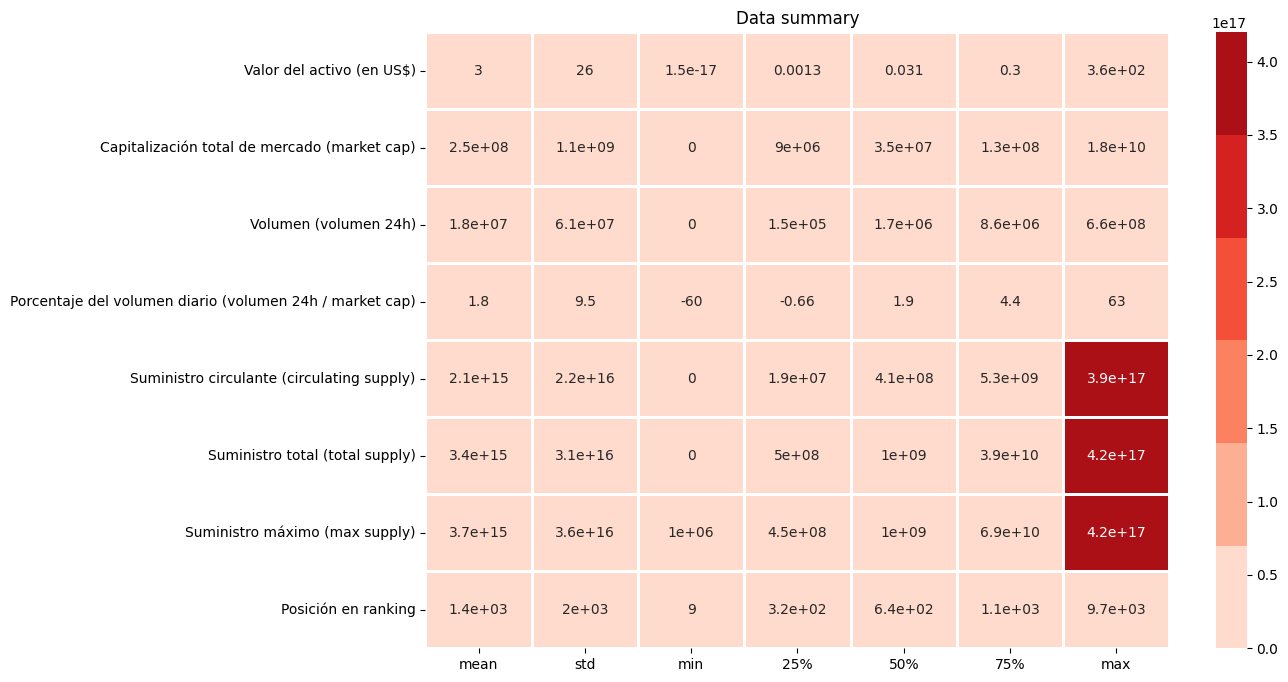

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(df.iloc[:,1:].describe()[1:].transpose(),
            annot=True,linecolor="w",
            linewidth=2,cmap=sns.color_palette("Reds"))
plt.title("Data summary")
plt.show()

<ipython-input-16-b4bb5ab6776f>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df["Capitalización total de mercado (market cap)"], ax=axes[0,0])
<ipython-input-16-b4bb5ab6776f>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df["Volumen (volumen 24h)"], ax=axes[0,1])
<ipython-input-16-b4bb5

<Axes: xlabel='Posición en ranking', ylabel='Density'>

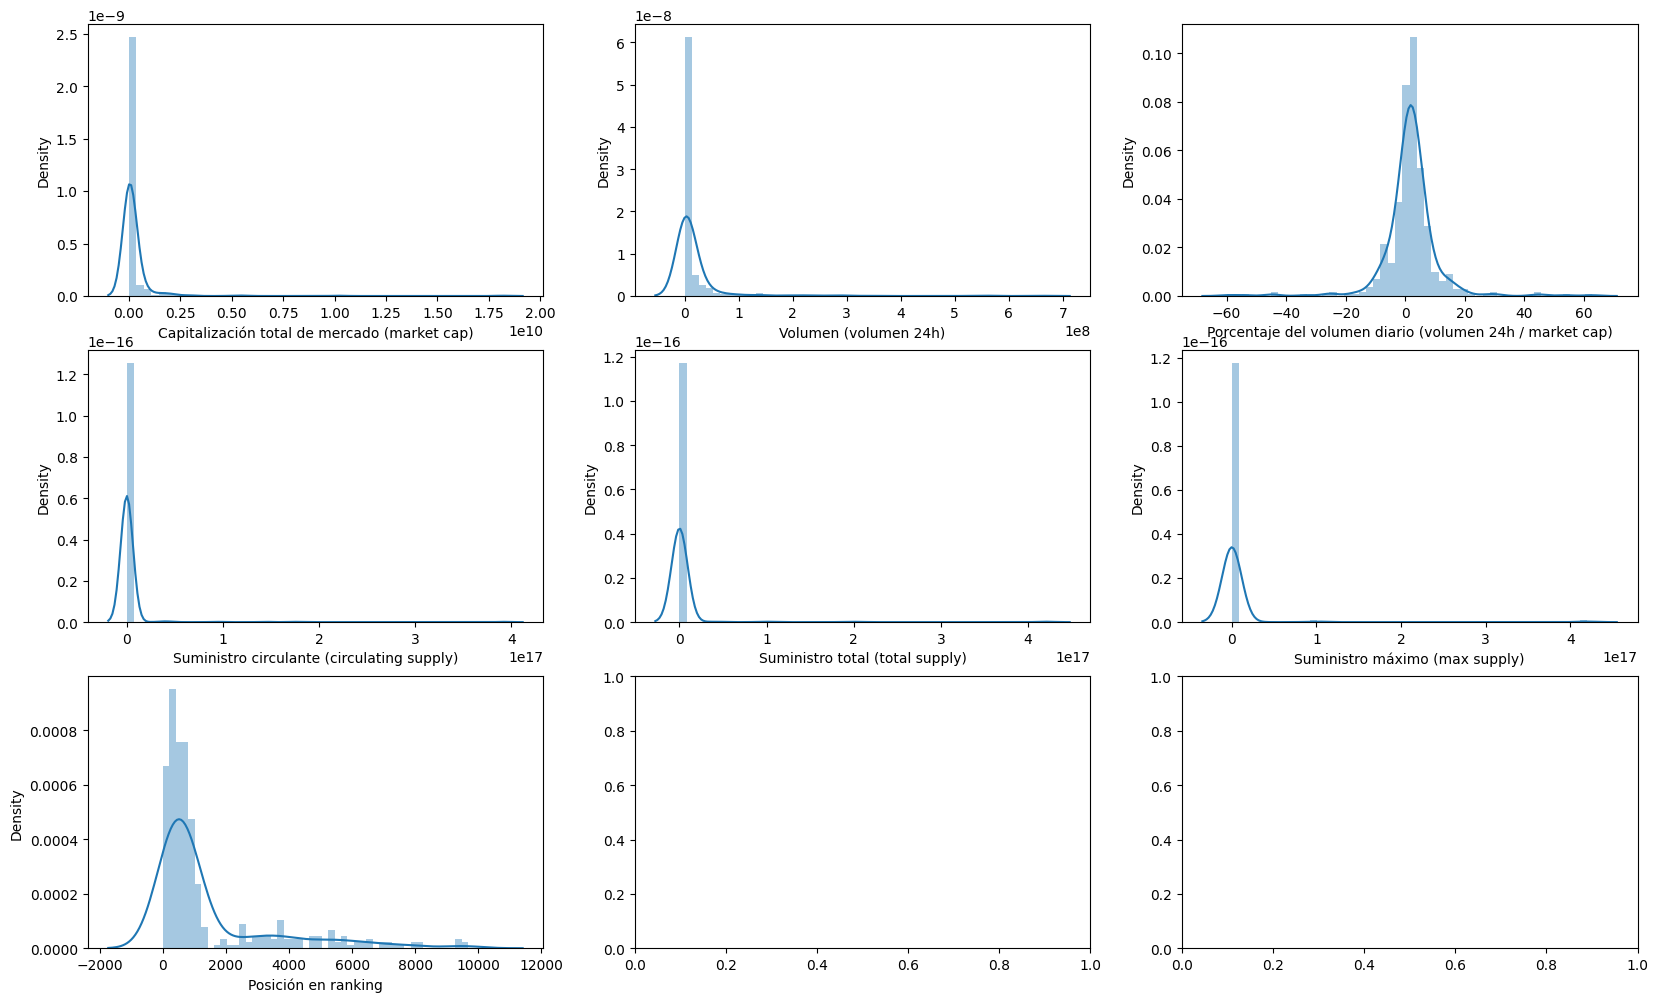

In [ ]:
# Display the histogram to undestand the data
f, axes = plt.subplots(3,3, figsize=(20, 12))
sns.distplot( df["Capitalización total de mercado (market cap)"], ax=axes[0,0])
sns.distplot( df["Volumen (volumen 24h)"], ax=axes[0,1])
sns.distplot( df["Porcentaje del volumen diario (volumen 24h / market cap)"], ax=axes[0,2])
sns.distplot( df["Suministro circulante (circulating supply)"], ax=axes[1,0])
sns.distplot( df["Suministro total (total supply)"], ax=axes[1,1])
sns.distplot( df["Suministro máximo (max supply)"], ax=axes[1,2])
sns.distplot( df["Posición en ranking"], ax=axes[2,0])

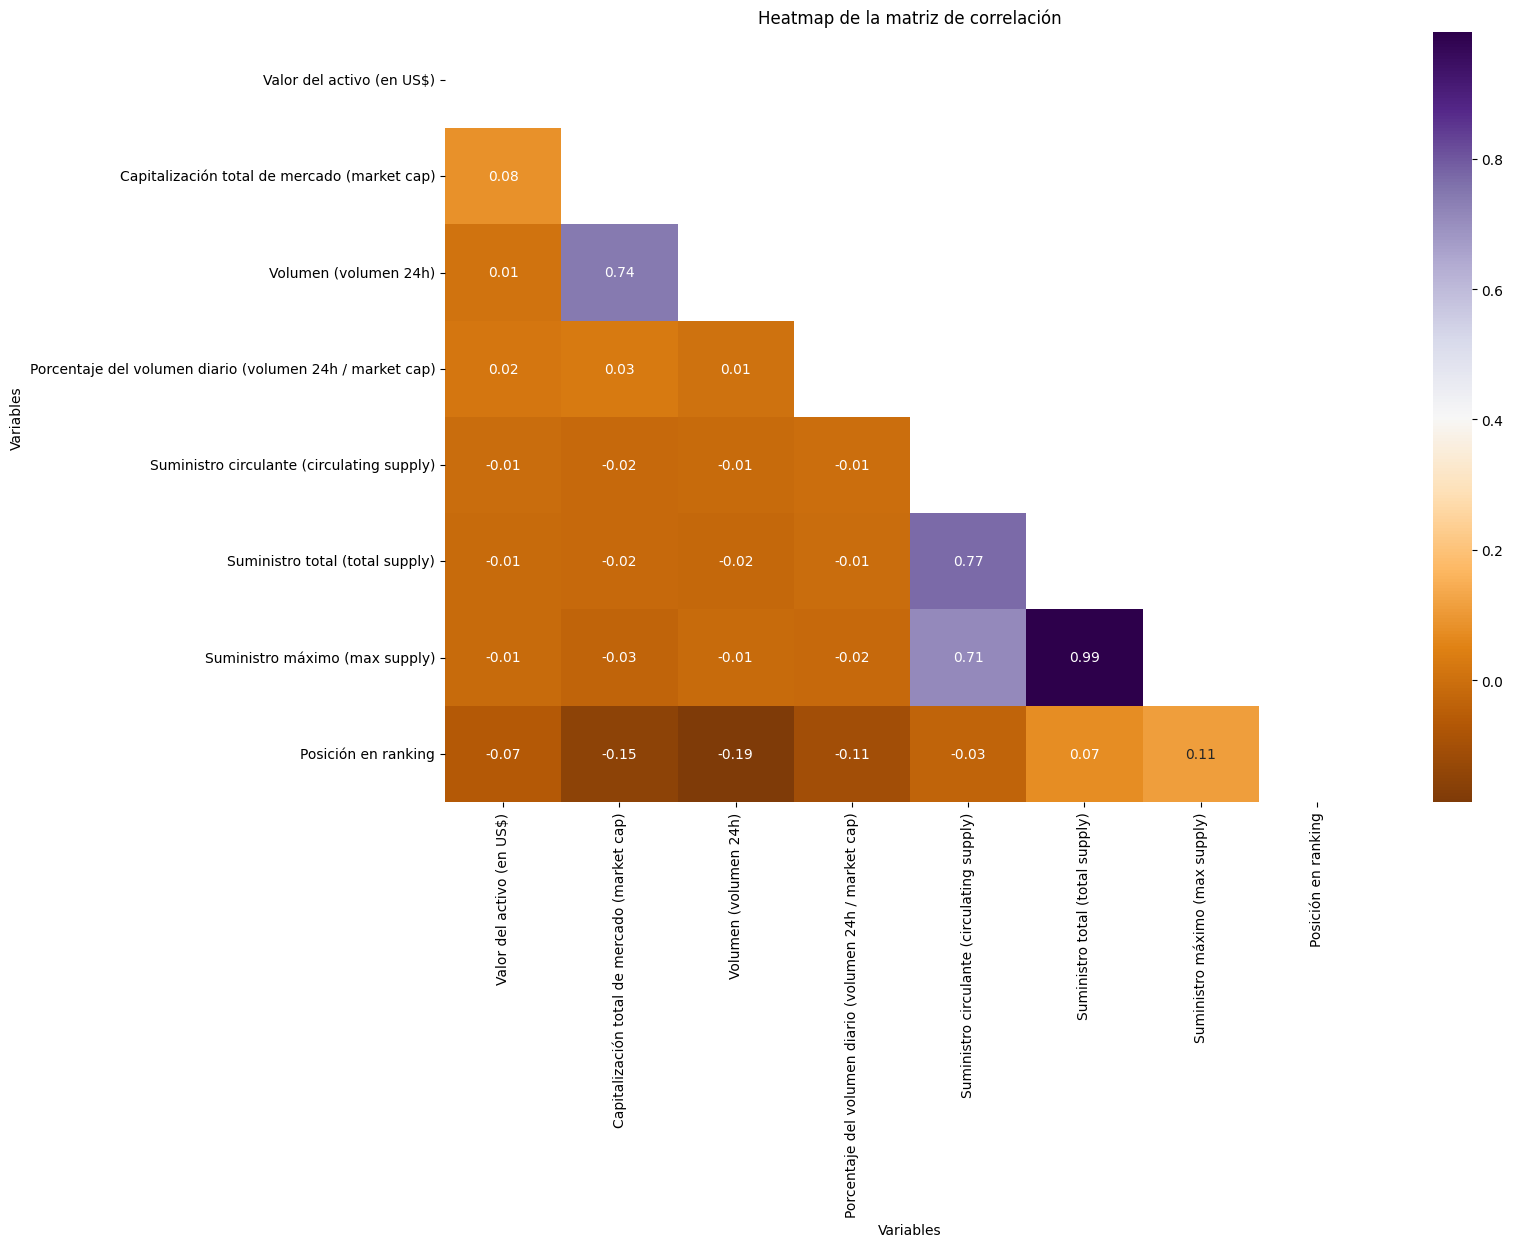

In [ ]:
# Compute the correlation matrix
df_subset = df.iloc[:,1:9]

if df_subset.empty:
    print("Error: El DataFrame está vacío.")
else:
    # Calcular la matriz de correlación
    corr_matrix = df_subset.corr()

    # Comprobar si la matriz de correlación contiene valores NaN
    if corr_matrix.isnull().values.any():
        print("Advertencia: La matriz de correlación contiene valores NaN.")
        print(corr_matrix)
    else:
        # Configurar el tamaño de la figura
        plt.figure(figsize=(15, 10))

        mask = np.zeros_like(corr_matrix, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        # Generar el heatmap de la matriz de correlación
        heatmap = sns.heatmap(data=corr_matrix, mask=mask, cmap="PuOr", annot=True, fmt=".2f")

        # Añadir títulos y etiquetas
        plt.title('Heatmap de la matriz de correlación')
        plt.xlabel('Variables')
        plt.ylabel('Variables')

        # Mostrar la figura
        plt.show()


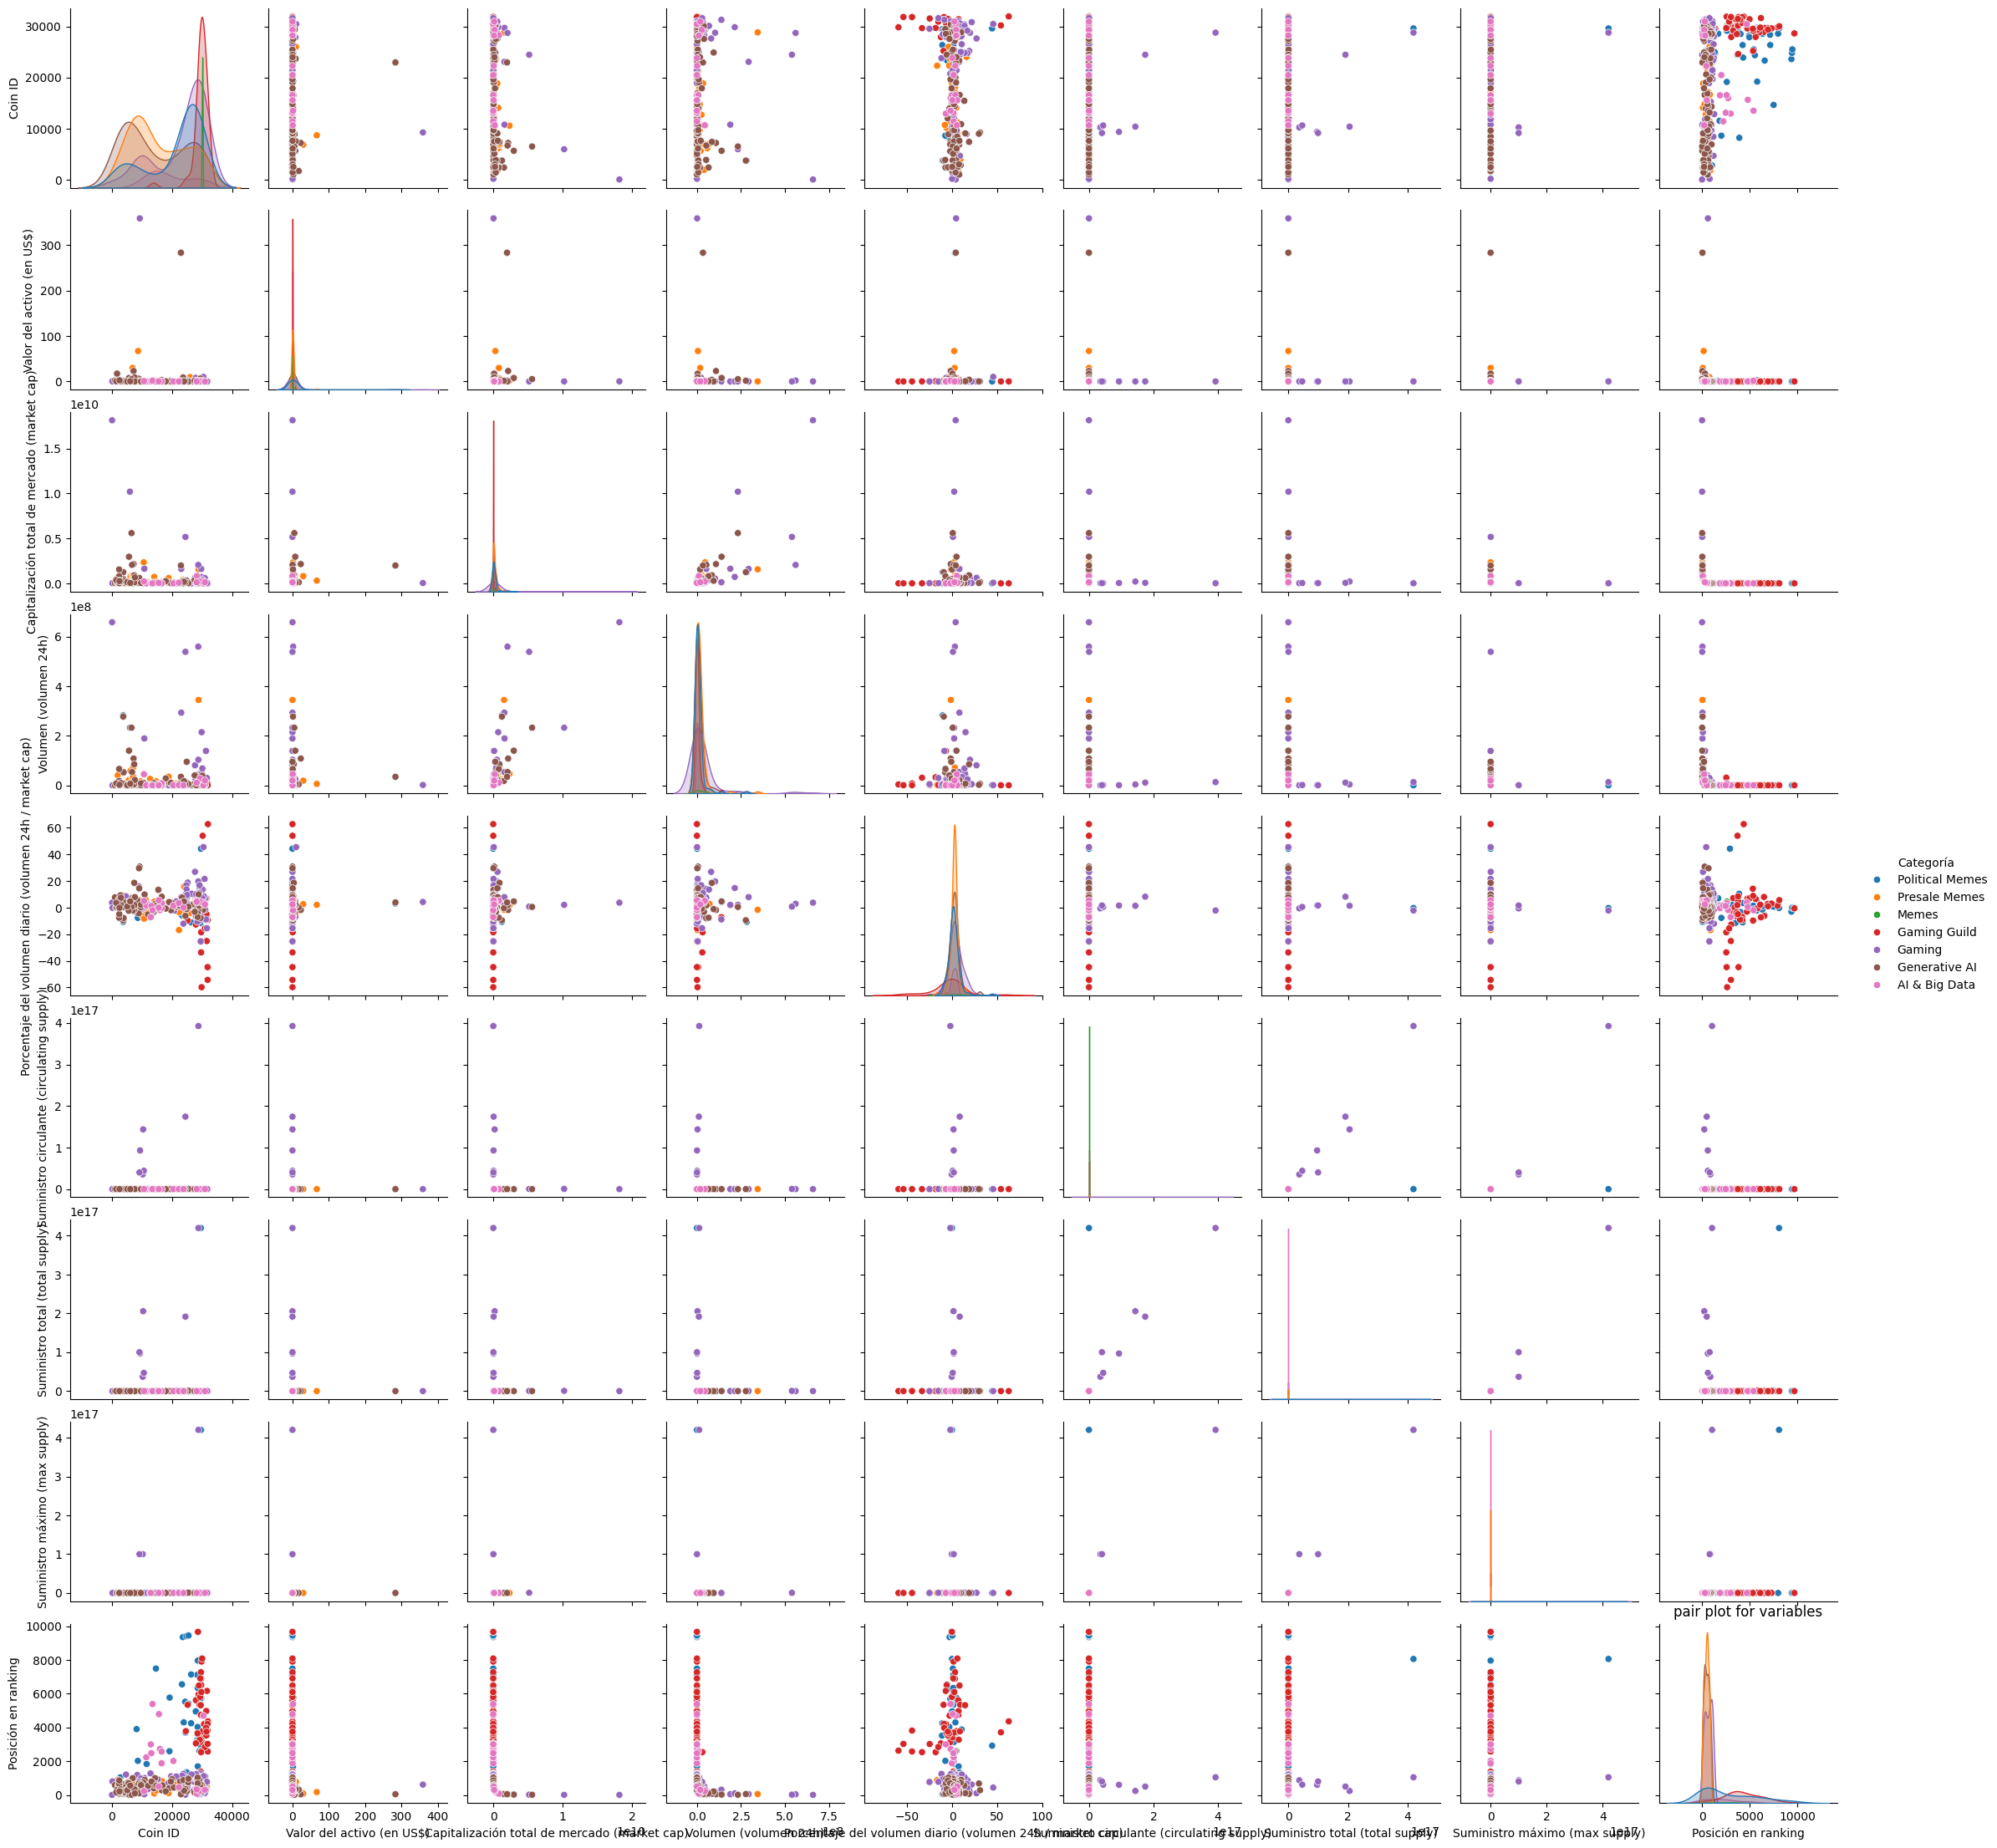

In [ ]:
sns.pairplot(df,hue="Categoría")
plt.title("pair plot for variables")
plt.show()

## Preprosesamiento de los datos

In [ ]:
null_values = df[df.isnull().any(axis=1)]
print("Filas con valores nulos:")
print(null_values)

Filas con valores nulos:
     Coin ID  Valor del activo (en US$)  \
0      25093                        NaN   
6       5690                   7.624730   
9      24141                        NaN   
11     14429                        NaN   
14     25226                        NaN   
..       ...                        ...   
447    11455                   0.000793   
448    10688                   0.586028   
450    13133                   0.000035   
451    13523                   1.642686   
453    15588                        NaN   

     Capitalización total de mercado (market cap)  Volumen (volumen 24h)  \
0                                             NaN           0.000000e+00   
6                                    2.963354e+09           1.405555e+08   
9                                             NaN           0.000000e+00   
11                                            NaN           0.000000e+00   
14                                            NaN           0.000000e+00   
..

In [ ]:
null_values

,Coin ID,Valor del activo (en US$),Capitalización total de mercado (market cap),Volumen (volumen 24h),Porcentaje del volumen diario (volumen 24h / market cap),Suministro circulante (circulating supply),Suministro total (total supply),Suministro máximo (max supply),Posición en ranking,Categoría
0,25093,NaN,NaN,0.000000e+00,0.000000,0.000000e+00,7.640000e+07,7.640000e+07,NaN,Political Memes
6,5690,7.624730,2.963354e+09,1.405555e+08,4.306933,3.886504e+08,5.320773e+08,NaN,29.0,Political Memes
9,24141,NaN,NaN,0.000000e+00,0.000000,0.000000e+00,5.200000e+10,1.000000e+11,NaN,Political Memes
11,14429,NaN,NaN,0.000000e+00,0.000000,0.000000e+00,5.000000e+07,1.000000e+08,NaN,Political Memes
14,25226,NaN,NaN,0.000000e+00,0.000000,0.000000e+00,1.000000e+11,NaN,NaN,Political Memes
...,...,...,...,...,...,...,...,...,...,...
447,11455,0.000793,1.223345e+05,1.388622e+04,1.572460,1.542943e+08,1.000000e+09,NaN,2236.0,AI & Big Data
448,10688,0.586028,2.141694e+08,4.441808e+07,5.080154,3.654593e+08,1.000000e+09,NaN,233.0,AI & Big Data
450,13133,0.000035,8.013068e+03,5.803508e+04,1.260110,2.266625e+08,3.133843e+08,NaN,2483.0,AI & Big Data
451,13523,1.642686,0.000000e+00,5.511797e+03,-1.956369,0.000000e+00,6.698112e+08,NaN,5392.0,AI & Big Data


In [ ]:
# Para contar los valores nulos en cada columna
null_count = df.isnull().sum()
print("=====================\n")
print("Valores nulos por columna:")
print(null_count)


Valores nulos por columna:
Coin ID                                                       0
Valor del activo (en US$)                                    16
Capitalización total de mercado (market cap)                 16
Volumen (volumen 24h)                                         0
Porcentaje del volumen diario (volumen 24h / market cap)      0
Suministro circulante (circulating supply)                    0
Suministro total (total supply)                               0
Suministro máximo (max supply)                              168
Posición en ranking                                          16
Categoría                                                     0
dtype: int64


In [ ]:
#Verificar proporciones de valores nulos
# Calcular proporciones de valores nulos en cada columna
proporcion_nulos = df.isnull().mean() * 100

# Imprimir las proporciones de valores nulos
print("Proporciones de valores nulos en cada columna:")
print(proporcion_nulos)

Proporciones de valores nulos en cada columna:
Coin ID                                                      0.000000
Valor del activo (en US$)                                    3.516484
Capitalización total de mercado (market cap)                 3.516484
Volumen (volumen 24h)                                        0.000000
Porcentaje del volumen diario (volumen 24h / market cap)     0.000000
Suministro circulante (circulating supply)                   0.000000
Suministro total (total supply)                              0.000000
Suministro máximo (max supply)                              36.923077
Posición en ranking                                          3.516484
Categoría                                                    0.000000
dtype: float64


In [ ]:
# Verificar duplicación de registros u observaciones
duplicados = df.duplicated()
num_duplicados = duplicados.sum()

# Imprimir el número de filas duplicadas
print(duplicados)
print("Número de filas duplicadas:", num_duplicados)

0      False
1      False
2      False
3      False
4      False
       ...  
450    False
451    False
452    False
453    False
454    False
Length: 455, dtype: bool
Número de filas duplicadas: 0


In [ ]:
import numpy as np
#Identificar variables con valores atipicos
# Seleccionar solo las columnas numéricas
df_numericas = df.select_dtypes(include=['int', 'float'])

# Calcular el rango intercuartílico (IQR) para cada columna numérica
Q1 = df_numericas.quantile(0.25)
Q3 = df_numericas.quantile(0.75)
IQR = Q3 - Q1

# Identificar valores atípicos para cada columna numérica
valores_atipicos = ((df_numericas < (Q1 - 1.5 * IQR)) | (df_numericas > (Q3 + 1.5 * IQR))).any()

# Método Z-Score
z_scores = (df_numericas - df_numericas.mean()) / df_numericas.std()
outliers_zscore = (np.abs(z_scores) > 3).any()

# Mostrar las columnas con valores atípicos
columnas_atipicas_iqr = valores_atipicos[valores_atipicos == True].index
print("Columnas con valores atípicos usando IQR:")
print(columnas_atipicas_iqr)
columnas_atipicas_zscore = outliers_zscore[outliers_zscore == True].index
print("Columnas atípicas con z-score:")
print(columnas_atipicas_zscore)

Columnas con valores atípicos usando IQR:
Index(['Valor del activo (en US$)',
       'Capitalización total de mercado (market cap)', 'Volumen (volumen 24h)',
       'Porcentaje del volumen diario (volumen 24h / market cap)',
       'Suministro circulante (circulating supply)',
       'Suministro total (total supply)', 'Suministro máximo (max supply)',
       'Posición en ranking'],
      dtype='object')
Columnas atípicas con z-score:
Index(['Valor del activo (en US$)',
       'Capitalización total de mercado (market cap)', 'Volumen (volumen 24h)',
       'Porcentaje del volumen diario (volumen 24h / market cap)',
       'Suministro circulante (circulating supply)',
       'Suministro total (total supply)', 'Suministro máximo (max supply)',
       'Posición en ranking'],
      dtype='object')


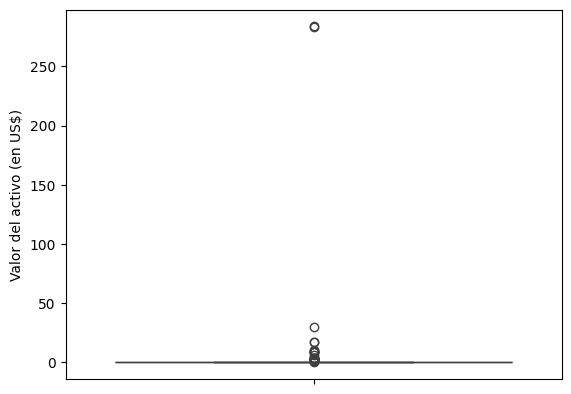

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que tienes un DataFrame df con los datos necesarios

# Manejo de valores faltantes (por ejemplo, eliminar filas con valores faltantes)
df_clean = df.dropna()

# Convertir la columna 'Categoría' en variables dummy si es necesario
df_clean = pd.get_dummies(df_clean, columns=['Categoría'])

# Crear el boxplot usando Seaborn
sns.boxplot(data=df_clean['Valor del activo (en US$)'])

# Rotar los nombres de las columnas para una mejor visualización
#plt.xticks(rotation=270)

# Mostrar el boxplot
plt.show()


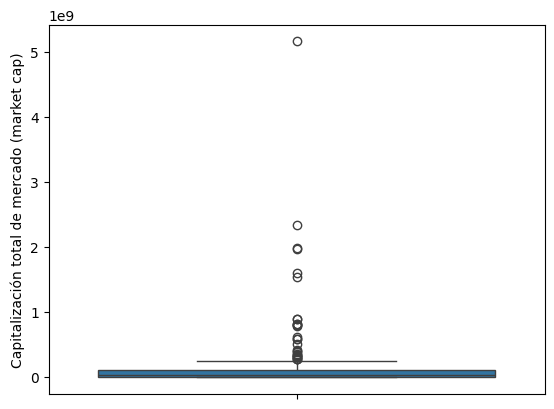

In [ ]:
sns.boxplot(data=df_clean['Capitalización total de mercado (market cap)'])
plt.show()

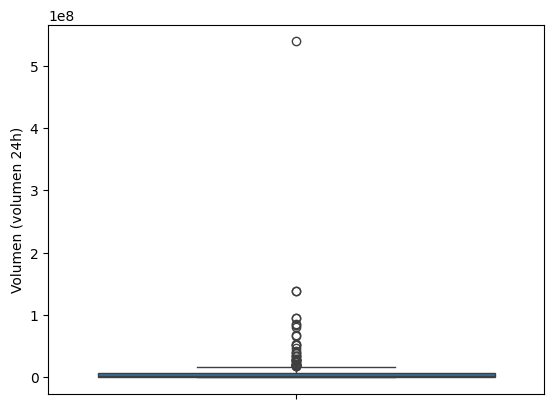

In [ ]:
sns.boxplot(data=df_clean['Volumen (volumen 24h)'])
plt.show()

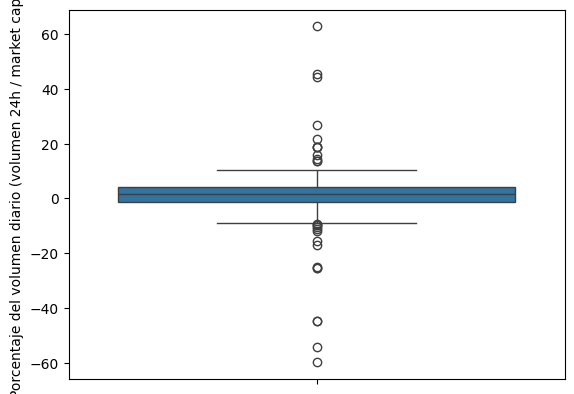

In [ ]:
sns.boxplot(data=df_clean['Porcentaje del volumen diario (volumen 24h / market cap)'])
plt.show()

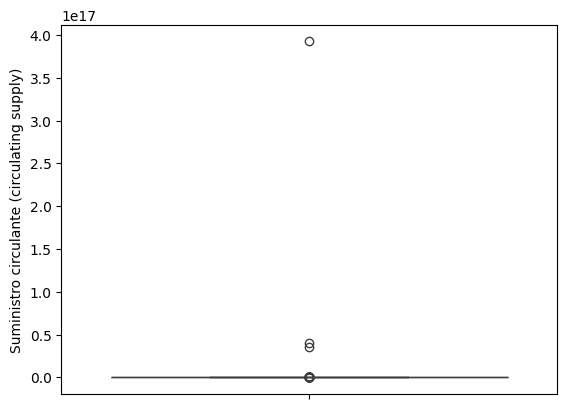

In [ ]:
sns.boxplot(data=df_clean['Suministro circulante (circulating supply)'])
plt.show()

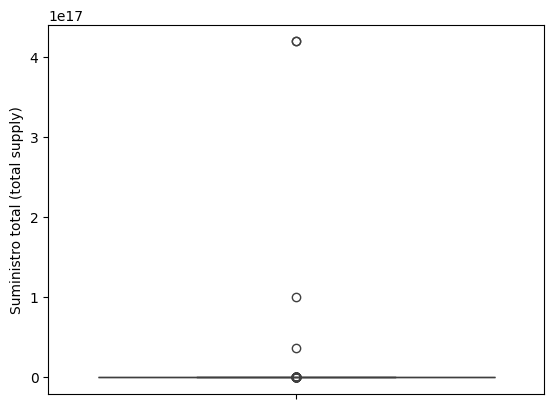

In [ ]:
sns.boxplot(data=df_clean['Suministro total (total supply)'])
plt.show()

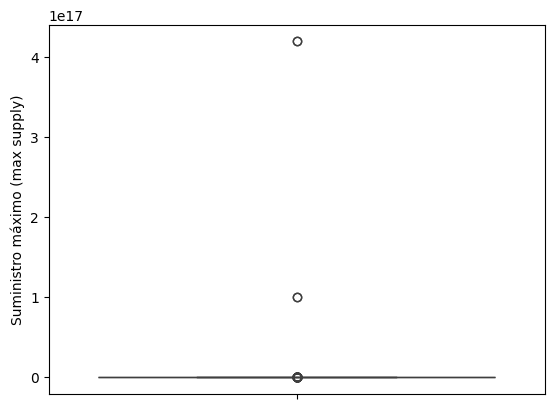

In [ ]:
sns.boxplot(data=df_clean['Suministro máximo (max supply)'])
plt.show()

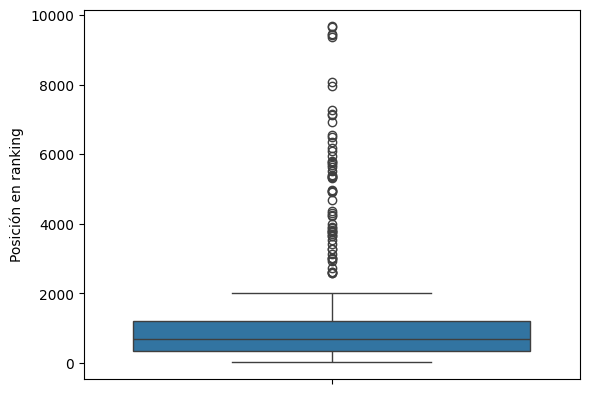

In [ ]:
sns.boxplot(data=df_clean['Posición en ranking'])
plt.show()


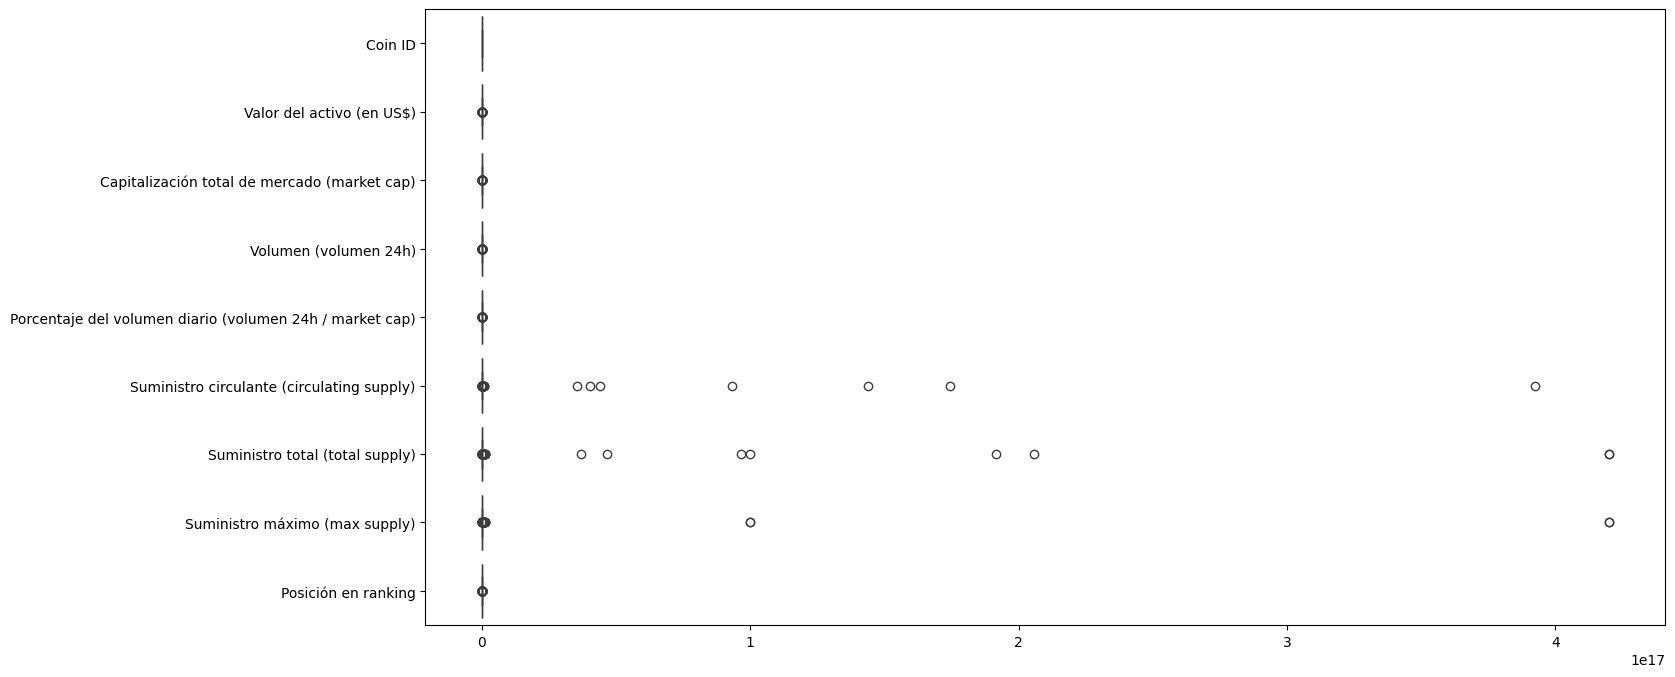

In [ ]:
plt.figure(figsize=(16,8))
sns.boxplot(df, orient = 'h')
plt.show()

### Limpieza de datos

In [ ]:
df_clean = df.copy()

* Datos Nulos

In [ ]:
df_clean.drop(["Suministro máximo (max supply)"], axis=1, inplace = True)

In [ ]:
#Verificamos que no existan datos faltantes
print("Valores faltantes después de la imputación:")
print(df_clean.isnull().sum())

Valores faltantes después de la imputación:
Coin ID                                                      0
Valor del activo (en US$)                                   16
Capitalización total de mercado (market cap)                16
Volumen (volumen 24h)                                        0
Porcentaje del volumen diario (volumen 24h / market cap)     0
Suministro circulante (circulating supply)                   0
Suministro total (total supply)                              0
Posición en ranking                                         16
Categoría                                                    0
dtype: int64


* Datos atípicos

In [ ]:
#Prueba de normalidad
#Ho: las variables se aproximan a una distribución normal
#Ha: las variables NO se aproximan a una distribución normal

#pvalue < 5% => Se rechaza la Ho, a un nivel de confianza de 95%,
#la variable no se aproxima a una distribución normal

#pvalue > 5% => No se rechaza la Ho, a un nivel de confianza de 95%,
#la variable se aproxima a una distribución normal
def test_normality(dataframe):
    results = {}

    for column in dataframe.columns:
        if pd.api.types.is_numeric_dtype(dataframe[column]):
            # Realizar el test de Shapiro-Wilk
            stat, p_value = stats.shapiro(dataframe[column].dropna())
            results[column] = {'W': stat, 'p-value': p_value}
        else:
            results[column] = {'W': None, 'p-value': None, 'error': 'Non-numeric column'}

    return results

results = test_normality(df_clean)
for column, result in results.items():
    print(f"Column: {column}")
    if 'error' in result:
        print(f"  Error: {result['error']}")
    else:
        print(f"  W: {result['W']:.4f}")
        print(f"  p-value: {result['p-value']:.4f}")

Column: Coin ID
  W: 0.8674
  p-value: 0.0000
Column: Valor del activo (en US$)
  W: 0.0864
  p-value: 0.0000
Column: Capitalización total de mercado (market cap)
  W: 0.1941
  p-value: 0.0000
Column: Volumen (volumen 24h)
  W: 0.2956
  p-value: 0.0000
Column: Porcentaje del volumen diario (volumen 24h / market cap)
  W: 0.7435
  p-value: 0.0000
Column: Suministro circulante (circulating supply)
  W: 0.0695
  p-value: 0.0000
Column: Suministro total (total supply)
  W: 0.0840
  p-value: 0.0000
Column: Posición en ranking
  W: 0.6565
  p-value: 0.0000
Column: Categoría
  Error: Non-numeric column


In [ ]:
def truncate_outliers(dataset, column):
    # Calcular percentiles y RIC
    percentile25 = dataset[column].quantile(0.25)
    percentile75 = dataset[column].quantile(0.75)
    ric = percentile75 - percentile25

    # Determinar límites superior e inferior
    upper_limit = percentile75 + 1.5 * ric
    lower_limit = percentile25 - 1.5 * ric

    # Aplicar los límites a la columna
    dataset[column] = np.where(
        dataset[column] > upper_limit,
        upper_limit,
        np.where(
            dataset[column] < lower_limit,
            lower_limit,
            dataset[column]
        )
    )
    return dataset

In [ ]:
truncate_outliers(df_clean, 'Valor del activo (en US$)')
truncate_outliers(df_clean, 'Capitalización total de mercado (market cap)')
truncate_outliers(df_clean, 'Volumen (volumen 24h)')
truncate_outliers(df_clean, 'Porcentaje del volumen diario (volumen 24h / market cap)')
truncate_outliers(df_clean, 'Suministro circulante (circulating supply)')
truncate_outliers(df_clean, 'Suministro total (total supply)')
truncate_outliers(df_clean, 'Posición en ranking')

,Coin ID,Valor del activo (en US$),Capitalización total de mercado (market cap),Volumen (volumen 24h),Porcentaje del volumen diario (volumen 24h / market cap),Suministro circulante (circulating supply),Suministro total (total supply),Posición en ranking,Categoría
0,25093,NaN,NaN,0.000000e+00,0.000000,0.000000e+00,7.640000e+07,NaN,Political Memes
1,14345,0.736764,3.543165e+07,7.569134e+05,2.690078,4.707368e+07,1.000000e+08,640.0,Political Memes
2,8230,0.014743,0.000000e+00,7.086302e+04,-3.597359,0.000000e+00,7.000000e+08,2231.0,Political Memes
3,27178,0.278434,2.279060e+08,3.609437e+06,2.314431,8.185281e+08,1.000000e+09,228.0,Political Memes
4,29750,0.110345,0.000000e+00,2.584294e+03,5.031140,0.000000e+00,1.000000e+08,2231.0,Political Memes
...,...,...,...,...,...,...,...,...,...
450,13133,0.000035,8.013068e+03,5.803508e+04,1.260110,2.266625e+08,3.133843e+08,2231.0,AI & Big Data
451,13523,0.736764,0.000000e+00,5.511797e+03,-1.956369,0.000000e+00,6.698112e+08,2231.0,AI & Big Data
452,15585,0.235662,5.943470e+07,4.549342e+02,5.558502,2.522029e+08,1.000000e+09,505.0,AI & Big Data
453,15588,NaN,NaN,0.000000e+00,0.000000,0.000000e+00,1.000000e+09,NaN,AI & Big Data


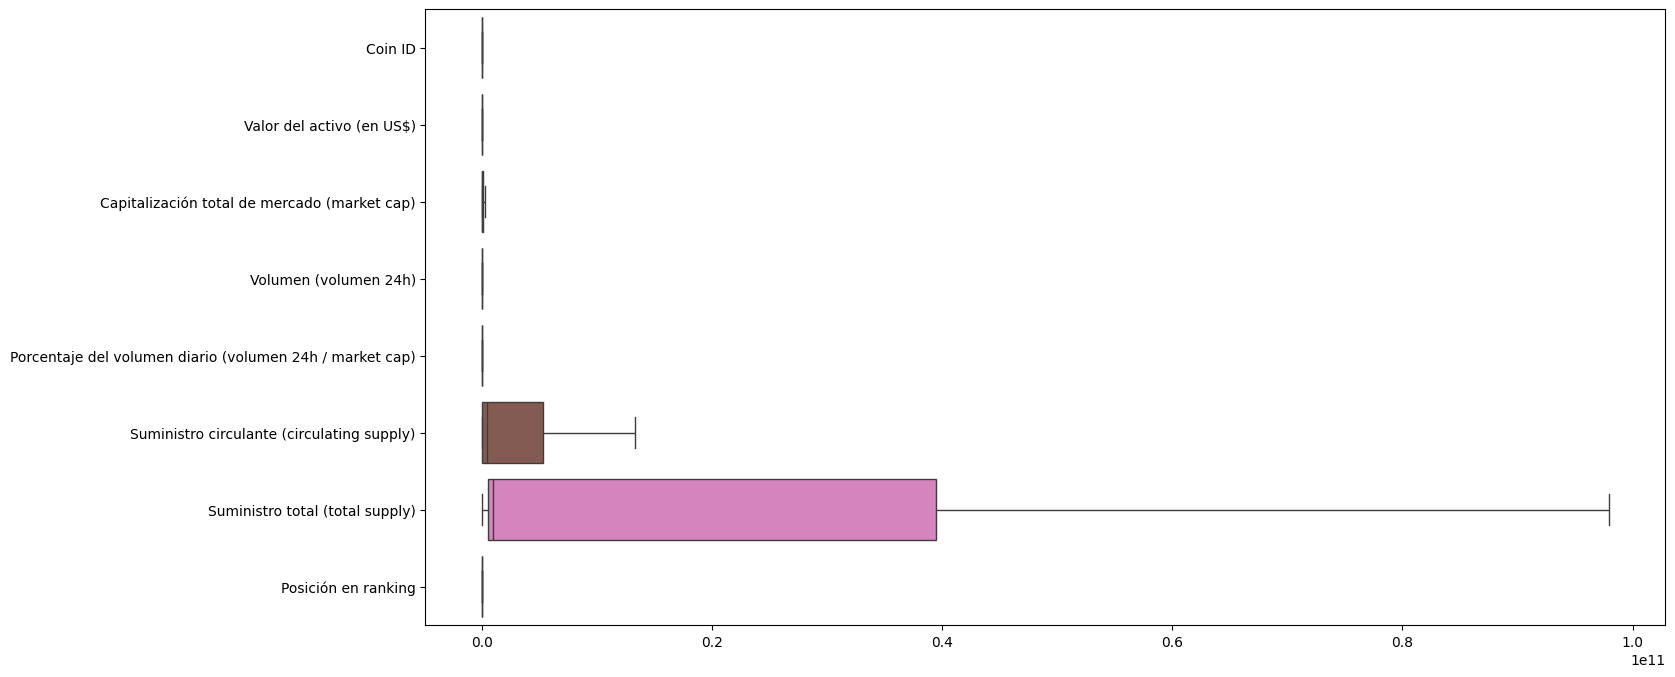

In [ ]:
plt.figure(figsize=(16,8))
sns.boxplot(df_clean, orient = 'h')
plt.show()

In [ ]:
df_clean.shape

(455, 9)

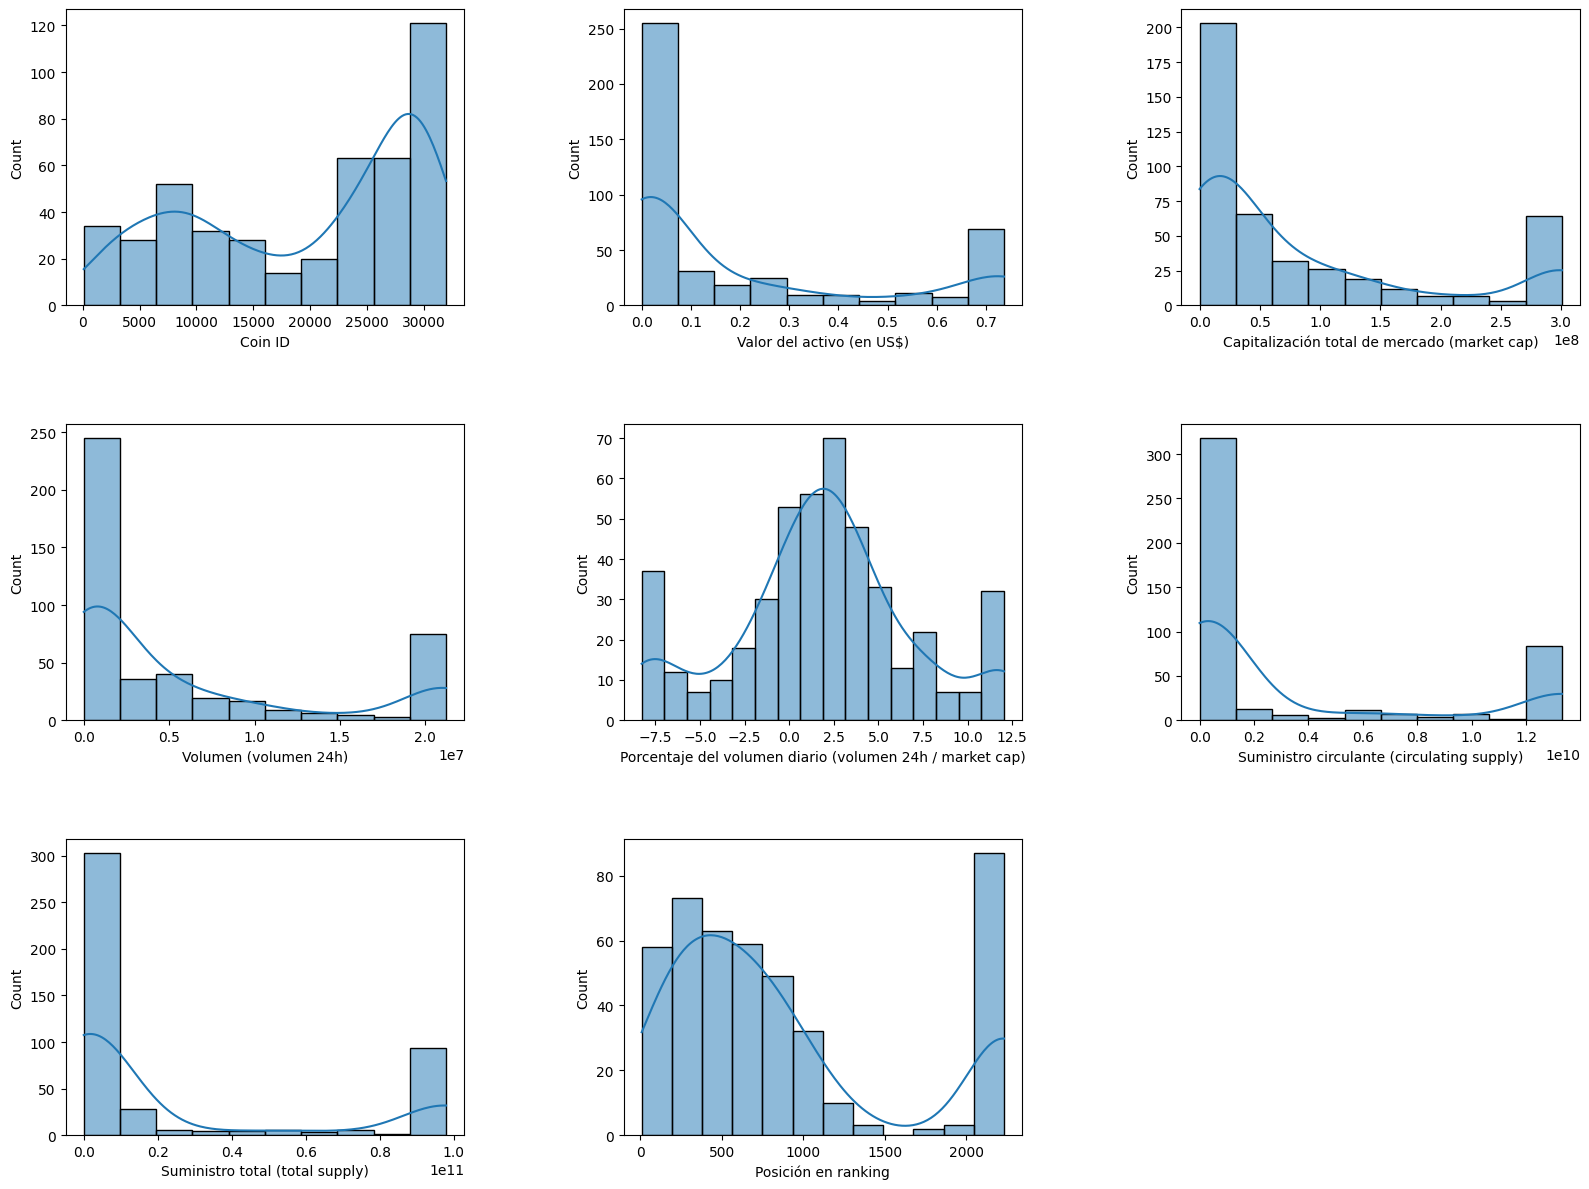

In [ ]:
plt.figure(figsize=(16, 12))
num_cols = len(df_clean.select_dtypes(include='number').columns)
num_rows = (num_cols + 2) // 3  # Calcular el número de filas necesario para una cuadrícula de 3 columnas
num_cols_plot = 3  # Número de columnas en la cuadrícula de gráficos

for i, column in enumerate(df_clean.select_dtypes(include='number').columns):
    plt.subplot(num_rows, num_cols_plot, i + 1)  # Ajustar dinámicamente la cuadrícula de subgráficos
    sns.histplot(df_clean[column], kde=True)  # Usar sns.histplot en lugar de sns.distplot
    plt.tight_layout()  # Ajustar automáticamente el espaciado de subgráficos

plt.subplots_adjust(hspace=0.4, wspace=0.4)  # Ajustar el espaciado entre subgráficos
plt.show()


In [ ]:
df_clean.to_csv('cryptos_info_clean.csv', index=False)

## Creación del modelo KNN

In [ ]:
df_clean = pd.read_csv('cryptos_info_clean.csv')

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 9 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Coin ID                                                   455 non-null    int64  
 1   Valor del activo (en US$)                                 439 non-null    float64
 2   Capitalización total de mercado (market cap)              439 non-null    float64
 3   Volumen (volumen 24h)                                     455 non-null    float64
 4   Porcentaje del volumen diario (volumen 24h / market cap)  455 non-null    float64
 5   Suministro circulante (circulating supply)                455 non-null    float64
 6   Suministro total (total supply)                           455 non-null    float64
 7   Posición en ranking                                       439 non-null    float64
 8   Categoría            

In [ ]:
df_clean.columns

Index(['Coin ID', 'Valor del activo (en US$)',
       'Capitalización total de mercado (market cap)', 'Volumen (volumen 24h)',
       'Porcentaje del volumen diario (volumen 24h / market cap)',
       'Suministro circulante (circulating supply)',
       'Suministro total (total supply)', 'Posición en ranking', 'Categoría'],
      dtype='object')

In [ ]:
X_data = df_clean.drop(["Coin ID", "Categoría"], axis=1)


In [ ]:
X_data

,Valor del activo (en US$),Capitalización total de mercado (market cap),Volumen (volumen 24h),Porcentaje del volumen diario (volumen 24h / market cap),Suministro circulante (circulating supply),Suministro total (total supply),Posición en ranking
0,NaN,NaN,0.000000e+00,0.000000,0.000000e+00,7.640000e+07,NaN
1,0.736764,3.543165e+07,7.569134e+05,2.690078,4.707368e+07,1.000000e+08,640.0
2,0.014743,0.000000e+00,7.086302e+04,-3.597359,0.000000e+00,7.000000e+08,2231.0
3,0.278434,2.279060e+08,3.609437e+06,2.314431,8.185281e+08,1.000000e+09,228.0
4,0.110345,0.000000e+00,2.584294e+03,5.031140,0.000000e+00,1.000000e+08,2231.0
...,...,...,...,...,...,...,...
450,0.000035,8.013068e+03,5.803508e+04,1.260110,2.266625e+08,3.133843e+08,2231.0
451,0.736764,0.000000e+00,5.511797e+03,-1.956369,0.000000e+00,6.698112e+08,2231.0
452,0.235662,5.943470e+07,4.549342e+02,5.558502,2.522029e+08,1.000000e+09,505.0
453,NaN,NaN,0.000000e+00,0.000000,0.000000e+00,1.000000e+09,NaN


In [ ]:
X = df_clean.iloc[:, 1:8].values
print(X)

[[           nan            nan 0.00000000e+00 ... 0.00000000e+00
  7.64000000e+07            nan]
 [7.36763700e-01 3.54316493e+07 7.56913439e+05 ... 4.70736815e+07
  1.00000000e+08 6.40000000e+02]
 [1.47430780e-02 0.00000000e+00 7.08630178e+04 ... 0.00000000e+00
  7.00000000e+08 2.23100000e+03]
 ...
 [2.35662225e-01 5.94346968e+07 4.54934185e+02 ... 2.52202901e+08
  1.00000000e+09 5.05000000e+02]
 [           nan            nan 0.00000000e+00 ... 0.00000000e+00
  1.00000000e+09            nan]
 [2.35699014e-02 1.29252833e+08 1.91133499e+07 ... 5.48380882e+09
  1.00000000e+10 3.09000000e+02]]


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
data_X_scale = pd.DataFrame(StandardScaler().fit_transform(X_data))
data_X_scale.columns = ['Valor del activo (en US$)',
       'Capitalización total de mercado (market cap)', 'Volumen (volumen 24h)',
       'Porcentaje del volumen diario (volumen 24h / market cap)',
       'Suministro circulante (circulating supply)',
       'Suministro total (total supply)', 'Posición en ranking']
data_X_scale.head()

,Valor del activo (en US$),Capitalización total de mercado (market cap),Volumen (volumen 24h),Porcentaje del volumen diario (volumen 24h / market cap),Suministro circulante (circulating supply),Suministro total (total supply),Posición en ranking
0,NaN,NaN,-0.756822,-0.359765,-0.640428,-0.628281,NaN
1,1.980506,-0.476892,-0.658088,0.174776,-0.631266,-0.627681,-0.327402
2,-0.661205,-0.819276,-0.747579,-1.074589,-0.640428,-0.612413,1.814195
3,0.303581,1.383033,-0.285997,0.100132,-0.481130,-0.604780,-0.881982
4,-0.311420,-0.819276,-0.756485,0.639964,-0.640428,-0.627681,1.814195


In [ ]:
from sklearn.impute import SimpleImputer
# Assume data_X_scale has NaN values
imputer = SimpleImputer(strategy='mean')
data_X_scale_imputed = imputer.fit_transform(data_X_scale)

kmeans = KMeans(n_clusters=5).fit(data_X_scale_imputed)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
labels = pd.DataFrame(kmeans.predict(data_X_scale_imputed))
labels.columns = ['segmento']
labels.head()

,segmento
0,3
1,3
2,0
3,1
4,0


In [ ]:
data_final = pd.concat([df_clean,labels], axis = 1)
data_final.head()

,Coin ID,Valor del activo (en US$),Capitalización total de mercado (market cap),Volumen (volumen 24h),Porcentaje del volumen diario (volumen 24h / market cap),Suministro circulante (circulating supply),Suministro total (total supply),Posición en ranking,Categoría,segmento
0,25093,NaN,NaN,0.000000e+00,0.000000,0.000000e+00,7.640000e+07,NaN,Political Memes,3
1,14345,0.736764,3.543165e+07,7.569134e+05,2.690078,4.707368e+07,1.000000e+08,640.0,Political Memes,3
2,8230,0.014743,0.000000e+00,7.086302e+04,-3.597359,0.000000e+00,7.000000e+08,2231.0,Political Memes,0
3,27178,0.278434,2.279060e+08,3.609437e+06,2.314431,8.185281e+08,1.000000e+09,228.0,Political Memes,1
4,29750,0.110345,0.000000e+00,2.584294e+03,5.031140,0.000000e+00,1.000000e+08,2231.0,Political Memes,0


In [ ]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 10 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Coin ID                                                   455 non-null    int64  
 1   Valor del activo (en US$)                                 439 non-null    float64
 2   Capitalización total de mercado (market cap)              439 non-null    float64
 3   Volumen (volumen 24h)                                     455 non-null    float64
 4   Porcentaje del volumen diario (volumen 24h / market cap)  455 non-null    float64
 5   Suministro circulante (circulating supply)                455 non-null    float64
 6   Suministro total (total supply)                           455 non-null    float64
 7   Posición en ranking                                       439 non-null    float64
 8   Categoría           

In [ ]:
data_final.groupby(['segmento'])[['Valor del activo (en US$)',
       'Capitalización total de mercado (market cap)', 'Volumen (volumen 24h)',
       'Porcentaje del volumen diario (volumen 24h / market cap)',
       'Suministro circulante (circulating supply)',
       'Suministro total (total supply)', 'Posición en ranking']].agg(['count','mean'])

Valor del activo (en US$)            \
                             count      mean   
segmento                                       
0                               91  0.039281   
1                               90  0.605208   
2                               67  0.000805   
3                              158  0.169016   
4                               33  0.030469   

         Capitalización total de mercado (market cap)                \
                                                count          mean   
segmento                                                              
0                                                  91  2.326643e+04   
1                                                  90  2.163124e+08   
2                                                  67  3.888584e+07   
3                                                 158  4.595073e+07   
4                                                  33  2.389045e+08   

         Volumen (volumen 24h)                \
                         count          mean   
segmento                                       
0                           91  9.345078e+05   
1                           90  1.357374e+07   
2                           68  2.922121e+06   
3                          173  2.761029e+06   
4                           33  1.990441e+07   

         Porcentaje del volumen diario (volumen 24h / market cap)            \
                                                            count      mean   
segmento                                                                      
0                                                        91       -0.162738   
1                                                        90        2.371971   
2                                                        68        2.868341   
3                                                       173        1.692206   
4                                                        33        4.161148   

         Suministro circulante (circulating supply)                \
                                              count          mean   
segmento                                                            
0                                                91  1.104259e+08   
1                                                90  4.528520e+08   
2                                                68  1.296526e+10   
3                                               173  1.138112e+09   
4                                                33  1.115000e+10   

         Suministro total (total supply)               Posición en ranking  \
                                   count          mean               count   
segmento                                                                     
0                                     91  2.844439e+10                  91   
1                                     90  8.836978e+08                  90   
2                                     68  8.512916e+10                  67   
3                                    173  4.917124e+09                 158   
4                                     33  5.944965e+10                  33   

                       
                 mean  
segmento               
0         2218.274725  
1          227.200000  
2          764.611940  
3          684.968354  
4          180.969697

##Evaluación

In [ ]:
!pip install yellowbrick

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

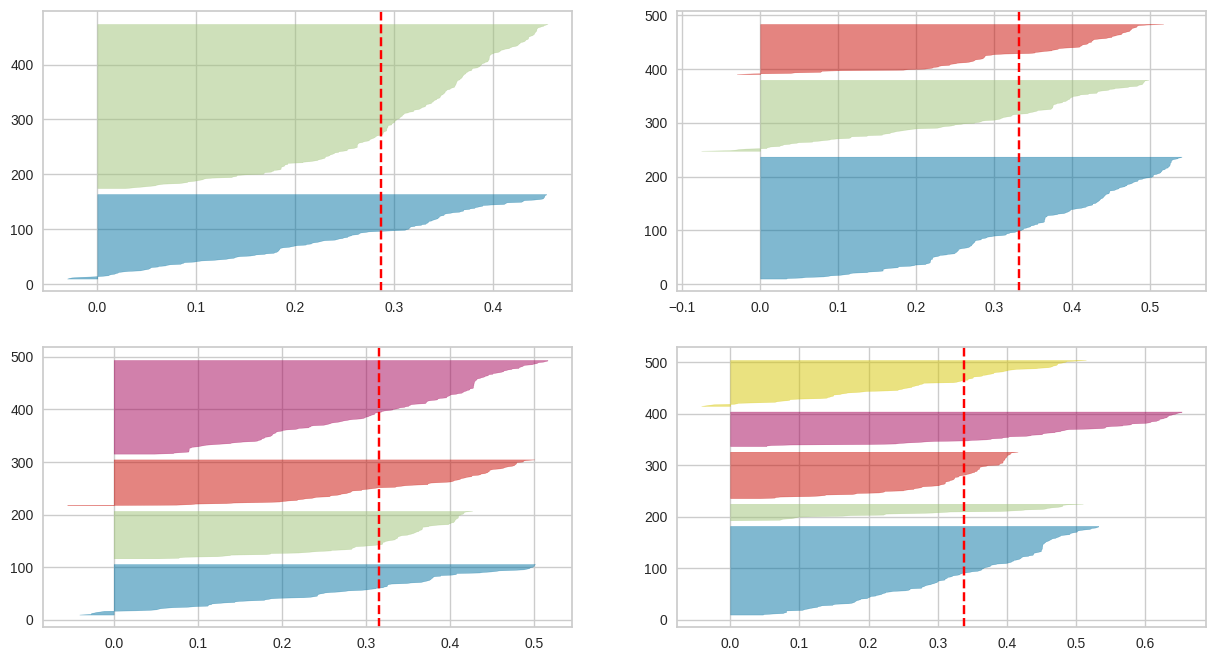

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    # Create KMeans instance for different number of clusters
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)

    # Create SilhouetteVisualizer instance with KMeans instance
    # Fit the visualizer
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(data_X_scale_imputed)

##***CatBoost***

In [ ]:
pip install catboost

In [ ]:

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

cb_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=10,
    eval_metric='RMSE',
    random_seed=42,
    bagging_temperature=0.2,
    od_type='Iter',
    metric_period=50,
    od_wait=20
)



X = df_clean.drop(["Coin ID", "Categoría"], axis=1)
y = df_clean["Categoría"]


le = LabelEncoder()
y_encoded = le.fit_transform(y)

dev_X, X_test, dev_y, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


cb_model.fit(dev_X, dev_y, eval_set=(X_test, y_test), verbose=50)

pred_test_cat = cb_model.predict(X_test)

pred_test_cat


0:	learn: 1.9545023	test: 2.0297038	best: 2.0297038 (0)	total: 14.7ms	remaining: 7.33s
50:	learn: 1.3820836	test: 1.8782456	best: 1.8765797 (45)	total: 690ms	remaining: 6.08s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1.87657974
bestIteration = 45

Shrink model to first 46 iterations.


array([3.68715512, 2.5886275 , 4.34822296, 3.99574174, 3.07346082,
       3.32251404, 2.02503409, 4.06366782, 4.30809773, 4.4926513 ,
       3.57072922, 3.52932301, 3.23461454, 4.05319555, 2.22749517,
       3.09470347, 4.03102542, 2.9428097 , 2.12682771, 4.0947987 ,
       3.42229519, 4.02083803, 1.98156737, 3.87703876, 2.31079315,
       3.7282581 , 2.50352797, 3.18360475, 3.90706031, 2.01169793,
       4.25516592, 1.97331765, 4.06387539, 4.09078759, 3.47380687,
       3.69105931, 4.48886575, 2.61780195, 2.99023427, 2.59906077,
       4.25516592, 3.70019094, 4.2245978 , 4.42647229, 4.1510796 ,
       2.17546321, 3.60045883, 2.18617862, 2.15001152, 2.58563467,
       3.43860377, 3.47761142, 2.17264565, 3.66819324, 4.32771102,
       3.32925078, 4.06463602, 4.12153106, 3.3680707 , 3.09575893,
       3.0624679 , 4.06463602, 4.11969795, 1.66150758, 3.3335318 ,
       3.93987305, 4.17364431, 2.84901486, 4.27618544, 3.13218932,
       4.17771094, 4.01476021, 3.11728219, 3.70953113, 2.06746

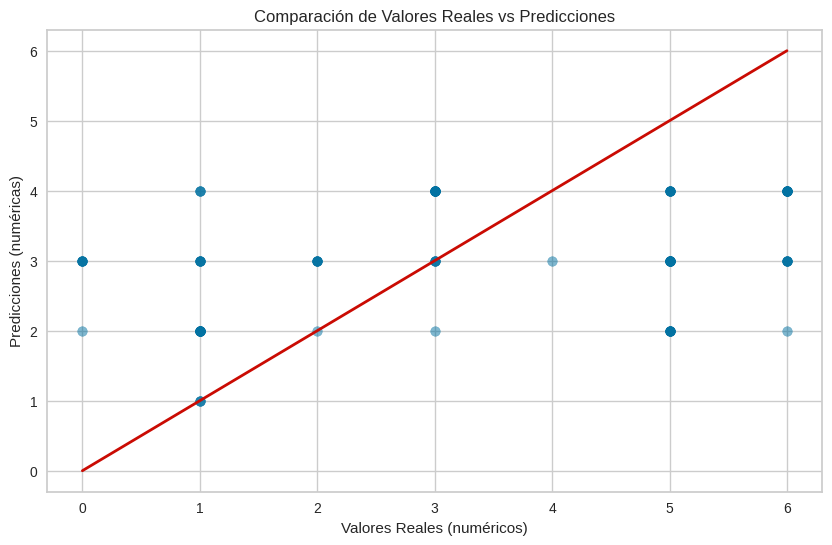

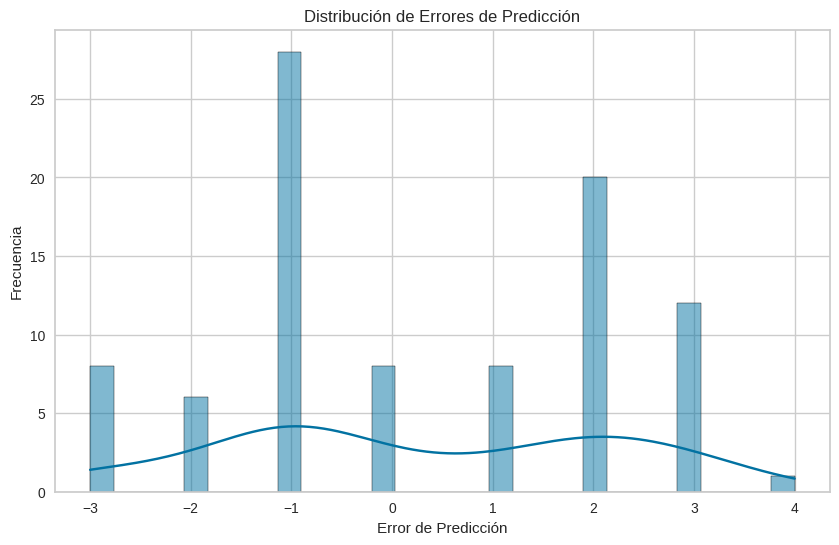

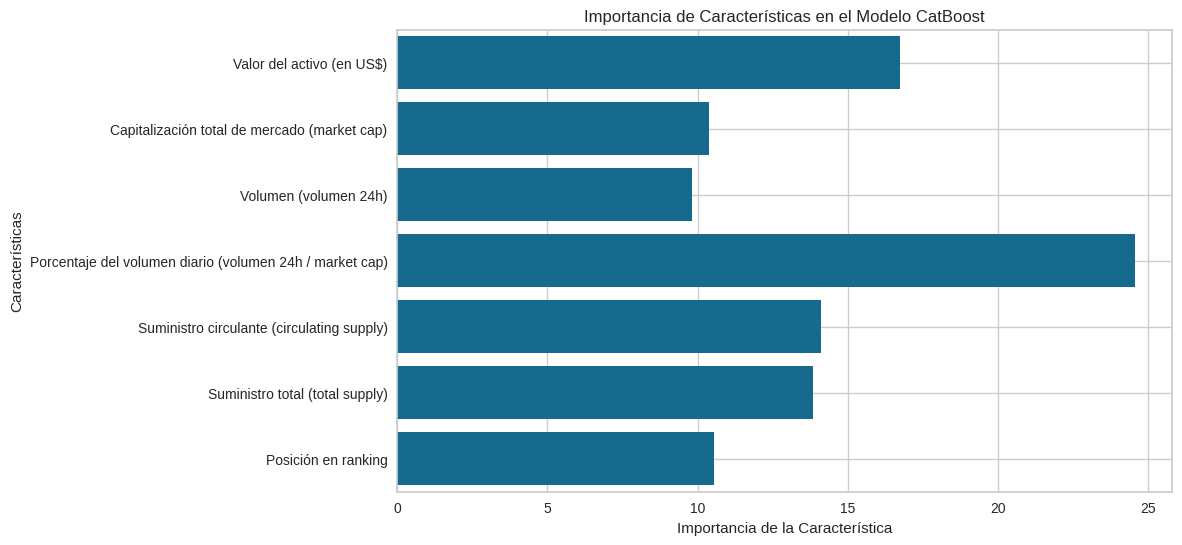

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Inversa de la codificación de etiquetas para obtener los valores originales
y_test_original = le.inverse_transform(y_test)
pred_test_cat_original = le.inverse_transform(pred_test_cat.astype(int))

# Convertir categorías a números para calcular errores
label_to_num = {label: num for num, label in enumerate(le.classes_)}
y_test_numeric = np.array([label_to_num[label] for label in y_test_original])
pred_test_numeric = np.array([label_to_num[label] for label in pred_test_cat_original])

# 1. Gráfico de Dispersión
plt.figure(figsize=(10, 6))
plt.scatter(y_test_numeric, pred_test_numeric, alpha=0.5, marker='o', color='b')
plt.plot([min(y_test_numeric), max(y_test_numeric)], [min(y_test_numeric), max(y_test_numeric)], color='r', linewidth=2)
plt.xlabel('Valores Reales (numéricos)')
plt.ylabel('Predicciones (numéricas)')
plt.title('Comparación de Valores Reales vs Predicciones')
plt.grid(True)
plt.show()

# 2. Histograma de Errores
errores = y_test_numeric - pred_test_numeric
plt.figure(figsize=(10, 6))
sns.histplot(errores, bins=30, kde=True)
plt.xlabel('Error de Predicción')
plt.ylabel('Frecuencia')
plt.title('Distribución de Errores de Predicción')
plt.grid(True)
plt.show()

# 3. Gráfico de Importancia de Características
feature_importances = cb_model.get_feature_importance()
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_names)
plt.xlabel('Importancia de la Característica')
plt.ylabel('Características')
plt.title('Importancia de Características en el Modelo CatBoost')
plt.grid(True)
plt.show()
